# 人脸生成（Face Generation）
在该项目中，你将使用生成式对抗网络（Generative Adversarial Nets）来生成新的人脸图像。
### 获取数据
该项目将使用以下数据集：
- MNIST
- CelebA

由于 CelebA 数据集比较复杂，而且这是你第一次使用 GANs。我们想让你先在 MNIST 数据集上测试你的 GANs 模型，以让你更快的评估所建立模型的性能。

如果你在使用 [FloydHub](https://www.floydhub.com/), 请将 `data_dir` 设置为 "/input" 并使用 [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
#data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## 探索数据（Explore the Data）
### MNIST
[MNIST](http://yann.lecun.com/exdb/mnist/) 是一个手写数字的图像数据集。你可以更改 `show_n_images` 探索此数据集。

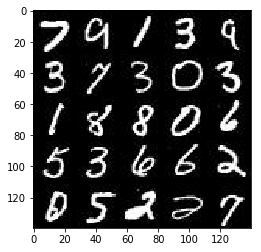

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
[CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) 是一个包含 20 多万张名人图片及相关图片说明的数据集。你将用此数据集生成人脸，不会用不到相关说明。你可以更改 `show_n_images` 探索此数据集。

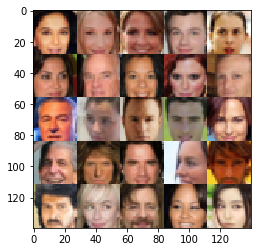

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## 预处理数据（Preprocess the Data）
由于该项目的重点是建立 GANs 模型，我们将为你预处理数据。

经过数据预处理，MNIST 和 CelebA 数据集的值在 28×28 维度图像的 [-0.5, 0.5] 范围内。CelebA 数据集中的图像裁剪了非脸部的图像部分，然后调整到 28x28 维度。

MNIST 数据集中的图像是单[通道](https://en.wikipedia.org/wiki/Channel_(digital_image%29)的黑白图像，CelebA 数据集中的图像是 [三通道的 RGB 彩色图像](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images)。

## 建立神经网络（Build the Neural Network）
你将通过部署以下函数来建立 GANs 的主要组成部分:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### 检查 TensorFlow 版本并获取 GPU 型号
检查你是否使用正确的 TensorFlow 版本，并获取 GPU 型号

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### 输入（Input）
部署 `model_inputs` 函数以创建用于神经网络的 [占位符 (TF Placeholders)](https://www.tensorflow.org/versions/r0.11/api_docs/python/io_ops/placeholders)。请创建以下占位符：
- 输入图像占位符: 使用 `image_width`，`image_height` 和 `image_channels` 设置为 rank 4。
- 输入 Z 占位符: 设置为 rank 2，并命名为 `z_dim`。
- 学习速率占位符: 设置为 rank 0。

返回占位符元组的形状为 (tensor of real input images, tensor of z data, learning rate)。


In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32,shape=(None,image_width,image_height,image_channels),name='input_real')
    input_z = tf.placeholder(tf.float32,shape=(None,z_dim),name='input_z')
    learning_rate = tf.placeholder(tf.float32,shape=[],name='learning_rate')

    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### 辨别器（Discriminator）
部署 `discriminator` 函数创建辨别器神经网络以辨别 `images`。该函数应能够重复使用神经网络中的各种变量。 在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "discriminator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回形如 (tensor output of the discriminator, tensor logits of the discriminator) 的元组。

In [6]:
def normalize_conv(input_layer,outputdim,kernel=4,stride=2,padding='same',is_training=True):
    conv = tf.layers.conv2d(input_layer,outputdim,kernel,stride,padding=padding,activation=None)
    conv = tf.layers.batch_normalization(conv,training=is_training)
    return conv

In [7]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        # images 28*28*3
        
        conv1 = tf.layers.conv2d(images,128,4,2,padding='same',activation=None)
        # conv1 14*14*128
        conv2 = normalize_conv(conv1, 256)
        conv2 = tf.maximum(conv2*0.2,conv2)
        # conv2 7*7*256
        conv3 = normalize_conv(conv2, 512)
        conv3 = tf.maximum(conv3*0.2,conv3)
        
        flat = tf.reshape(conv3,(-1,4*4*512))
        logits = tf.layers.dense(flat,1)
        output = tf.nn.sigmoid(logits)
        

    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### 生成器（Generator）
部署 `generator` 函数以使用 `z` 生成图像。该函数应能够重复使用神经网络中的各种变量。
在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "generator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回所生成的 28 x 28 x `out_channel_dim` 维度图像。

In [8]:
def normalize_deconv(input_layer,outputdim,kernel=4,stride=2,padding='same',is_training=True):
    conv = tf.layers.conv2d_transpose(input_layer,outputdim,kernel,stride,padding=padding,activation=None)
    conv = tf.layers.batch_normalization(conv,training=is_training)
    return conv

In [9]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not is_train):
        # input of z dim_z
        project = tf.layers.dense(z, 4*4*512)
        reshape = tf.reshape(project, (-1,4,4,512))
        # reshape 4*4*512
        deconv1 = normalize_deconv(reshape,256,stride=1,padding='valid')
        deconv1 = tf.maximum(deconv1*0.2,deconv1)
        # deconv 7*7*256
        deconv2 = normalize_deconv(deconv1,128)
        deconv2 = tf.maximum(deconv2*0.2,deconv2)
        # deconv2 14*14*128
        logit = normalize_deconv(deconv2, out_channel_dim)
        output = tf.tanh(logit)*0.5
    
    return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### 损失函数（Loss）
部署 `model_loss` 函数训练并计算 GANs 的损失。该函数应返回形如 (discriminator loss, generator loss) 的元组。

使用你已实现的函数：
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [10]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real,
                                                                        labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                                        labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                                   labels=tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### 优化（Optimization）
部署 `model_opt` 函数实现对 GANs 的优化。使用 [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) 获取可训练的所有变量。通过变量空间名 `discriminator` 和 `generator` 来过滤变量。该函数应返回形如 (discriminator training operation, generator training operation) 的元组。

In [11]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate,beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate,beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## 训练神经网络（Neural Network Training）
### 输出显示
使用该函数可以显示生成器 (Generator) 在训练过程中的当前输出，这会帮你评估 GANs 模型的训练程度。

In [12]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### 训练
部署 `train` 函数以建立并训练 GANs 模型。记得使用以下你已完成的函数：
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

使用 `show_generator_output` 函数显示 `generator` 在训练过程中的输出。

**注意**：在每个批次 (batch) 中运行 `show_generator_output` 函数会显著增加训练时间与该 notebook 的体积。推荐每 100 批次输出一次 `generator` 的输出。 

In [13]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    steps = 0 
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_z = np.random.uniform(-1,1,size=(batch_size,z_dim))
                
                _ = sess.run(d_train_opt, feed_dict={input_real:batch_images,
                                                    input_z:batch_z,
                                                    lr:learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_real:batch_images,
                                                    input_z:batch_z,
                                                    lr:learning_rate})
                batch_z = np.random.uniform(-1,1,size=(batch_size,z_dim))
                _ = sess.run(g_train_opt, feed_dict={input_real:batch_images,
                                                    input_z:batch_z,
                                                    lr:learning_rate})
                if steps % 20 == 0:
                    train_loss_d = d_loss.eval({input_z:batch_z,input_real:batch_images})
                    train_loss_g = g_loss.eval({input_z:batch_z})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                if steps % 200 ==0:
                    show_generator_output(sess,16,input_z,data_shape[3],data_image_mode)
                
                

### MNIST
在 MNIST 上测试你的 GANs 模型。经过 2 次迭代，GANs 应该能够生成类似手写数字的图像。确保生成器 (generator) 低于辨别器 (discriminator) 的损失，或接近 0。

Epoch 1/2... Discriminator Loss: 0.3669... Generator Loss: 2.1233
Epoch 1/2... Discriminator Loss: 0.0449... Generator Loss: 4.4401
Epoch 1/2... Discriminator Loss: 0.0197... Generator Loss: 5.2626
Epoch 1/2... Discriminator Loss: 0.0428... Generator Loss: 3.3913
Epoch 1/2... Discriminator Loss: 0.0215... Generator Loss: 4.5750
Epoch 1/2... Discriminator Loss: 0.0119... Generator Loss: 4.6919
Epoch 1/2... Discriminator Loss: 0.0067... Generator Loss: 6.2293
Epoch 1/2... Discriminator Loss: 0.0056... Generator Loss: 5.4673
Epoch 1/2... Discriminator Loss: 0.0068... Generator Loss: 5.4173
Epoch 1/2... Discriminator Loss: 0.0155... Generator Loss: 5.0124


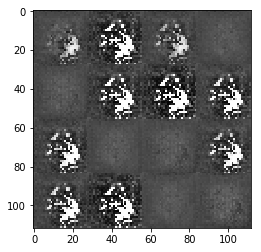

Epoch 1/2... Discriminator Loss: 0.0011... Generator Loss: 7.1468
Epoch 1/2... Discriminator Loss: 0.0028... Generator Loss: 6.2797
Epoch 1/2... Discriminator Loss: 0.0012... Generator Loss: 7.3092
Epoch 1/2... Discriminator Loss: 0.0028... Generator Loss: 6.3938
Epoch 1/2... Discriminator Loss: 0.0038... Generator Loss: 5.9607
Epoch 1/2... Discriminator Loss: 0.0058... Generator Loss: 5.6878
Epoch 1/2... Discriminator Loss: 0.0007... Generator Loss: 7.6266
Epoch 1/2... Discriminator Loss: 0.0024... Generator Loss: 6.6007
Epoch 1/2... Discriminator Loss: 0.0007... Generator Loss: 8.1201
Epoch 1/2... Discriminator Loss: 0.0007... Generator Loss: 7.5810


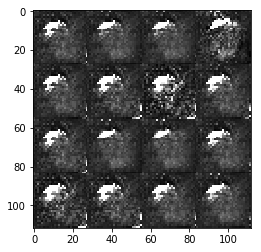

Epoch 1/2... Discriminator Loss: 0.0009... Generator Loss: 8.1096
Epoch 1/2... Discriminator Loss: 0.0004... Generator Loss: 8.5268
Epoch 1/2... Discriminator Loss: 0.4279... Generator Loss: 1.0695
Epoch 1/2... Discriminator Loss: 1.0196... Generator Loss: 0.8991
Epoch 1/2... Discriminator Loss: 0.1363... Generator Loss: 3.6906
Epoch 1/2... Discriminator Loss: 0.0880... Generator Loss: 3.1763
Epoch 1/2... Discriminator Loss: 1.3192... Generator Loss: 0.3645
Epoch 1/2... Discriminator Loss: 0.1482... Generator Loss: 2.5800
Epoch 1/2... Discriminator Loss: 0.0498... Generator Loss: 3.5498
Epoch 1/2... Discriminator Loss: 0.0394... Generator Loss: 6.6056


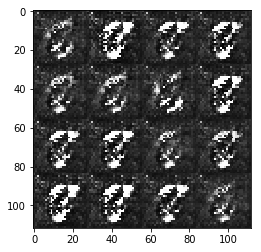

Epoch 1/2... Discriminator Loss: 0.0127... Generator Loss: 5.1743
Epoch 1/2... Discriminator Loss: 0.0089... Generator Loss: 5.2006
Epoch 1/2... Discriminator Loss: 0.0012... Generator Loss: 7.1628
Epoch 1/2... Discriminator Loss: 0.0035... Generator Loss: 6.2333
Epoch 1/2... Discriminator Loss: 0.0052... Generator Loss: 5.8411
Epoch 1/2... Discriminator Loss: 0.0018... Generator Loss: 7.2375
Epoch 1/2... Discriminator Loss: 0.0014... Generator Loss: 7.5614
Epoch 1/2... Discriminator Loss: 0.0012... Generator Loss: 7.2583
Epoch 1/2... Discriminator Loss: 0.0007... Generator Loss: 7.6456
Epoch 1/2... Discriminator Loss: 0.0009... Generator Loss: 7.7534


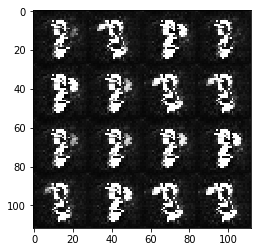

Epoch 1/2... Discriminator Loss: 0.0007... Generator Loss: 7.8237
Epoch 1/2... Discriminator Loss: 0.0010... Generator Loss: 7.6190
Epoch 1/2... Discriminator Loss: 0.0015... Generator Loss: 7.0336
Epoch 1/2... Discriminator Loss: 0.0008... Generator Loss: 7.6597
Epoch 1/2... Discriminator Loss: 0.0016... Generator Loss: 7.0272
Epoch 1/2... Discriminator Loss: 0.0014... Generator Loss: 7.3895
Epoch 1/2... Discriminator Loss: 0.0005... Generator Loss: 8.0289
Epoch 1/2... Discriminator Loss: 0.0012... Generator Loss: 7.9775
Epoch 1/2... Discriminator Loss: 0.0023... Generator Loss: 7.6090
Epoch 1/2... Discriminator Loss: 0.0006... Generator Loss: 8.0769


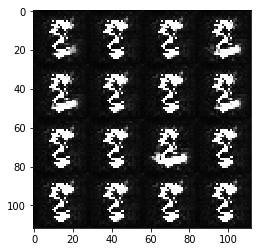

Epoch 1/2... Discriminator Loss: 0.0003... Generator Loss: 8.7459
Epoch 1/2... Discriminator Loss: 0.0002... Generator Loss: 8.6348
Epoch 1/2... Discriminator Loss: 0.0004... Generator Loss: 8.3156
Epoch 1/2... Discriminator Loss: 0.0005... Generator Loss: 8.3357
Epoch 1/2... Discriminator Loss: 0.0003... Generator Loss: 8.2371
Epoch 1/2... Discriminator Loss: 0.8502... Generator Loss: 3.3068
Epoch 1/2... Discriminator Loss: 1.8324... Generator Loss: 0.2771
Epoch 1/2... Discriminator Loss: 0.6685... Generator Loss: 3.5275
Epoch 1/2... Discriminator Loss: 0.3617... Generator Loss: 1.8645
Epoch 1/2... Discriminator Loss: 1.0996... Generator Loss: 1.0555


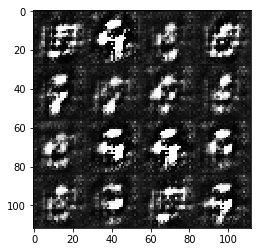

Epoch 1/2... Discriminator Loss: 0.5375... Generator Loss: 2.2952
Epoch 1/2... Discriminator Loss: 0.6184... Generator Loss: 1.5749
Epoch 1/2... Discriminator Loss: 0.9280... Generator Loss: 5.0297
Epoch 1/2... Discriminator Loss: 0.4051... Generator Loss: 1.5883
Epoch 1/2... Discriminator Loss: 1.3100... Generator Loss: 0.3403
Epoch 1/2... Discriminator Loss: 2.8996... Generator Loss: 7.9252
Epoch 1/2... Discriminator Loss: 0.6809... Generator Loss: 0.9264
Epoch 1/2... Discriminator Loss: 0.4473... Generator Loss: 1.0995
Epoch 1/2... Discriminator Loss: 0.1775... Generator Loss: 4.0099
Epoch 1/2... Discriminator Loss: 0.2507... Generator Loss: 1.7634


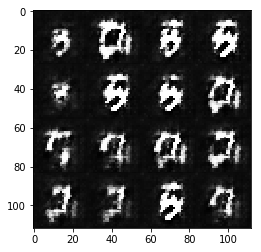

Epoch 1/2... Discriminator Loss: 0.3945... Generator Loss: 3.2566
Epoch 1/2... Discriminator Loss: 0.1943... Generator Loss: 3.5831
Epoch 1/2... Discriminator Loss: 0.0885... Generator Loss: 4.7170
Epoch 1/2... Discriminator Loss: 0.2083... Generator Loss: 2.1379
Epoch 1/2... Discriminator Loss: 0.4819... Generator Loss: 1.2769
Epoch 1/2... Discriminator Loss: 0.1088... Generator Loss: 3.0223
Epoch 1/2... Discriminator Loss: 0.2676... Generator Loss: 1.7647
Epoch 1/2... Discriminator Loss: 0.1952... Generator Loss: 2.4832
Epoch 1/2... Discriminator Loss: 1.3779... Generator Loss: 0.3349
Epoch 1/2... Discriminator Loss: 0.4286... Generator Loss: 2.3790


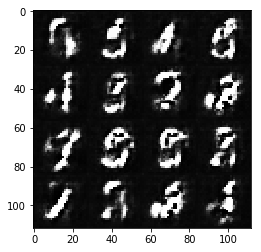

Epoch 1/2... Discriminator Loss: 1.3478... Generator Loss: 0.3383
Epoch 1/2... Discriminator Loss: 0.2476... Generator Loss: 2.9380
Epoch 1/2... Discriminator Loss: 0.2788... Generator Loss: 1.6716
Epoch 1/2... Discriminator Loss: 0.0937... Generator Loss: 3.2847
Epoch 1/2... Discriminator Loss: 0.2382... Generator Loss: 2.1211
Epoch 1/2... Discriminator Loss: 2.7660... Generator Loss: 6.2591
Epoch 1/2... Discriminator Loss: 2.3161... Generator Loss: 0.1196
Epoch 1/2... Discriminator Loss: 0.8239... Generator Loss: 3.2129
Epoch 1/2... Discriminator Loss: 0.2391... Generator Loss: 2.0915
Epoch 1/2... Discriminator Loss: 1.6058... Generator Loss: 5.1617


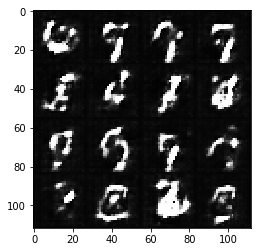

Epoch 1/2... Discriminator Loss: 0.5257... Generator Loss: 3.3090
Epoch 1/2... Discriminator Loss: 0.1413... Generator Loss: 2.8889
Epoch 1/2... Discriminator Loss: 0.3415... Generator Loss: 1.5187
Epoch 2/2... Discriminator Loss: 0.6199... Generator Loss: 2.5377
Epoch 2/2... Discriminator Loss: 0.3574... Generator Loss: 2.9581
Epoch 2/2... Discriminator Loss: 0.5953... Generator Loss: 3.1082
Epoch 2/2... Discriminator Loss: 0.5118... Generator Loss: 2.7117
Epoch 2/2... Discriminator Loss: 0.5486... Generator Loss: 0.9805
Epoch 2/2... Discriminator Loss: 0.8544... Generator Loss: 2.7014
Epoch 2/2... Discriminator Loss: 0.3365... Generator Loss: 1.6085


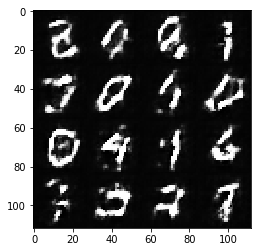

Epoch 2/2... Discriminator Loss: 1.0950... Generator Loss: 0.4659
Epoch 2/2... Discriminator Loss: 0.6407... Generator Loss: 0.8990
Epoch 2/2... Discriminator Loss: 0.4961... Generator Loss: 1.8599
Epoch 2/2... Discriminator Loss: 1.2636... Generator Loss: 3.4952
Epoch 2/2... Discriminator Loss: 1.1227... Generator Loss: 0.4671
Epoch 2/2... Discriminator Loss: 1.3303... Generator Loss: 3.2667
Epoch 2/2... Discriminator Loss: 1.4755... Generator Loss: 4.9446
Epoch 2/2... Discriminator Loss: 0.5232... Generator Loss: 1.1114
Epoch 2/2... Discriminator Loss: 0.4777... Generator Loss: 1.5575
Epoch 2/2... Discriminator Loss: 0.5853... Generator Loss: 0.9762


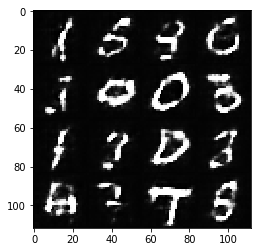

Epoch 2/2... Discriminator Loss: 0.5966... Generator Loss: 1.6358
Epoch 2/2... Discriminator Loss: 1.0800... Generator Loss: 0.4944
Epoch 2/2... Discriminator Loss: 0.9259... Generator Loss: 0.5886
Epoch 2/2... Discriminator Loss: 0.9544... Generator Loss: 0.6004
Epoch 2/2... Discriminator Loss: 1.6461... Generator Loss: 3.8328
Epoch 2/2... Discriminator Loss: 1.2315... Generator Loss: 2.9061
Epoch 2/2... Discriminator Loss: 0.9256... Generator Loss: 2.5480
Epoch 2/2... Discriminator Loss: 0.8000... Generator Loss: 1.0958
Epoch 2/2... Discriminator Loss: 0.7590... Generator Loss: 2.5254
Epoch 2/2... Discriminator Loss: 1.8090... Generator Loss: 0.2219


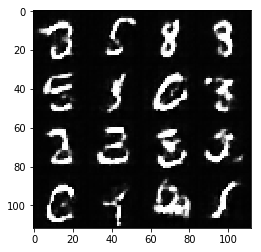

Epoch 2/2... Discriminator Loss: 0.7329... Generator Loss: 0.8006
Epoch 2/2... Discriminator Loss: 0.8545... Generator Loss: 0.6621
Epoch 2/2... Discriminator Loss: 1.0875... Generator Loss: 2.3228
Epoch 2/2... Discriminator Loss: 1.3127... Generator Loss: 2.8662
Epoch 2/2... Discriminator Loss: 0.9026... Generator Loss: 3.1520
Epoch 2/2... Discriminator Loss: 0.5869... Generator Loss: 1.0789
Epoch 2/2... Discriminator Loss: 1.1930... Generator Loss: 2.4682
Epoch 2/2... Discriminator Loss: 2.0585... Generator Loss: 3.7583
Epoch 2/2... Discriminator Loss: 1.2810... Generator Loss: 0.3891
Epoch 2/2... Discriminator Loss: 1.4223... Generator Loss: 2.3299


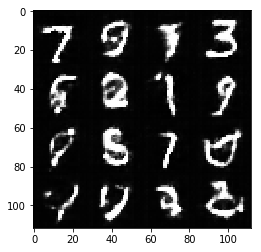

Epoch 2/2... Discriminator Loss: 2.2007... Generator Loss: 0.1364
Epoch 2/2... Discriminator Loss: 0.8849... Generator Loss: 0.6786
Epoch 2/2... Discriminator Loss: 0.9730... Generator Loss: 0.6998
Epoch 2/2... Discriminator Loss: 0.9826... Generator Loss: 0.5816
Epoch 2/2... Discriminator Loss: 1.9116... Generator Loss: 3.7937
Epoch 2/2... Discriminator Loss: 0.6997... Generator Loss: 1.1368
Epoch 2/2... Discriminator Loss: 0.9949... Generator Loss: 0.9743
Epoch 2/2... Discriminator Loss: 1.9134... Generator Loss: 2.9720
Epoch 2/2... Discriminator Loss: 0.7689... Generator Loss: 1.9913
Epoch 2/2... Discriminator Loss: 0.9737... Generator Loss: 1.7629


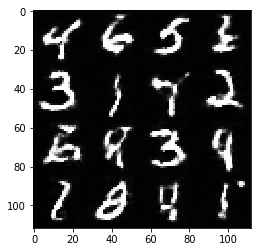

Epoch 2/2... Discriminator Loss: 0.6026... Generator Loss: 1.1934
Epoch 2/2... Discriminator Loss: 1.5631... Generator Loss: 0.2878
Epoch 2/2... Discriminator Loss: 0.9242... Generator Loss: 1.1869
Epoch 2/2... Discriminator Loss: 1.7262... Generator Loss: 0.2739
Epoch 2/2... Discriminator Loss: 1.0502... Generator Loss: 0.7870
Epoch 2/2... Discriminator Loss: 0.8702... Generator Loss: 1.0455
Epoch 2/2... Discriminator Loss: 0.8657... Generator Loss: 0.7169
Epoch 2/2... Discriminator Loss: 1.3473... Generator Loss: 1.6776
Epoch 2/2... Discriminator Loss: 1.3476... Generator Loss: 0.5169
Epoch 2/2... Discriminator Loss: 0.9213... Generator Loss: 1.7876


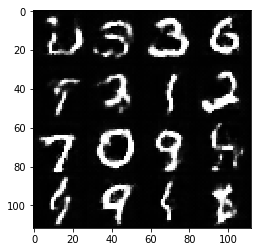

Epoch 2/2... Discriminator Loss: 1.0289... Generator Loss: 0.5350
Epoch 2/2... Discriminator Loss: 1.2850... Generator Loss: 0.4908
Epoch 2/2... Discriminator Loss: 1.1494... Generator Loss: 0.5963
Epoch 2/2... Discriminator Loss: 0.9065... Generator Loss: 1.5268
Epoch 2/2... Discriminator Loss: 1.2699... Generator Loss: 1.7810
Epoch 2/2... Discriminator Loss: 1.2966... Generator Loss: 1.6821
Epoch 2/2... Discriminator Loss: 1.1860... Generator Loss: 1.6905
Epoch 2/2... Discriminator Loss: 0.8514... Generator Loss: 1.1030
Epoch 2/2... Discriminator Loss: 1.3433... Generator Loss: 2.4159
Epoch 2/2... Discriminator Loss: 1.3737... Generator Loss: 0.3618


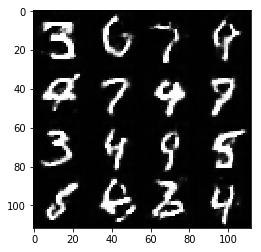

Epoch 2/2... Discriminator Loss: 1.3482... Generator Loss: 0.4467
Epoch 2/2... Discriminator Loss: 1.3283... Generator Loss: 1.8804
Epoch 2/2... Discriminator Loss: 1.1538... Generator Loss: 0.6422
Epoch 2/2... Discriminator Loss: 1.0881... Generator Loss: 0.5844
Epoch 2/2... Discriminator Loss: 1.0817... Generator Loss: 0.8969
Epoch 2/2... Discriminator Loss: 1.0229... Generator Loss: 0.7308
Epoch 2/2... Discriminator Loss: 1.0407... Generator Loss: 1.4744
Epoch 2/2... Discriminator Loss: 1.1023... Generator Loss: 0.6441
Epoch 2/2... Discriminator Loss: 1.4296... Generator Loss: 1.9377
Epoch 2/2... Discriminator Loss: 0.7085... Generator Loss: 1.4158


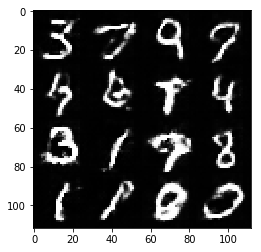

Epoch 2/2... Discriminator Loss: 1.1469... Generator Loss: 0.5049
Epoch 2/2... Discriminator Loss: 0.9921... Generator Loss: 0.7377
Epoch 2/2... Discriminator Loss: 1.1692... Generator Loss: 0.5273
Epoch 2/2... Discriminator Loss: 0.8740... Generator Loss: 1.4357
Epoch 2/2... Discriminator Loss: 1.5050... Generator Loss: 0.3345
Epoch 2/2... Discriminator Loss: 1.1650... Generator Loss: 0.5756
Epoch 2/2... Discriminator Loss: 1.1868... Generator Loss: 0.6170
Epoch 2/2... Discriminator Loss: 1.0550... Generator Loss: 0.7638
Epoch 2/2... Discriminator Loss: 1.2125... Generator Loss: 1.6905
Epoch 2/2... Discriminator Loss: 1.1592... Generator Loss: 1.5659


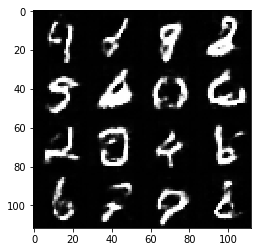

Epoch 2/2... Discriminator Loss: 1.2399... Generator Loss: 1.4653
Epoch 2/2... Discriminator Loss: 1.1194... Generator Loss: 0.7916
Epoch 2/2... Discriminator Loss: 1.0794... Generator Loss: 0.8986
Epoch 2/2... Discriminator Loss: 0.9850... Generator Loss: 0.8266
Epoch 2/2... Discriminator Loss: 0.9199... Generator Loss: 1.1198
Epoch 2/2... Discriminator Loss: 1.3581... Generator Loss: 0.5976
Epoch 2/2... Discriminator Loss: 1.5980... Generator Loss: 0.3153


In [14]:
batch_size = 32
z_dim = 100
learning_rate = 0.0004
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
在 CelebA 上运行你的 GANs 模型。在一般的GPU上运行每次迭代大约需要 20 分钟。你可以运行整个迭代，或者当 GANs 开始产生真实人脸图像时停止它。

Epoch 1/1... Discriminator Loss: 0.1201... Generator Loss: 5.6295
Epoch 1/1... Discriminator Loss: 0.0935... Generator Loss: 3.0019
Epoch 1/1... Discriminator Loss: 0.3359... Generator Loss: 1.6349
Epoch 1/1... Discriminator Loss: 0.1804... Generator Loss: 2.8714
Epoch 1/1... Discriminator Loss: 0.1416... Generator Loss: 2.6149
Epoch 1/1... Discriminator Loss: 1.1494... Generator Loss: 0.6414
Epoch 1/1... Discriminator Loss: 0.1393... Generator Loss: 2.7137
Epoch 1/1... Discriminator Loss: 1.3043... Generator Loss: 0.6670
Epoch 1/1... Discriminator Loss: 0.3068... Generator Loss: 2.0240
Epoch 1/1... Discriminator Loss: 1.2665... Generator Loss: 0.5444


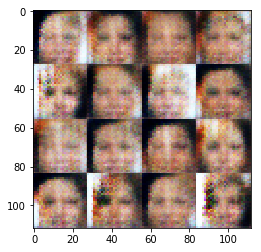

Epoch 1/1... Discriminator Loss: 0.2424... Generator Loss: 2.3928
Epoch 1/1... Discriminator Loss: 0.4526... Generator Loss: 3.4282
Epoch 1/1... Discriminator Loss: 2.1647... Generator Loss: 0.1923
Epoch 1/1... Discriminator Loss: 1.2882... Generator Loss: 0.7014
Epoch 1/1... Discriminator Loss: 0.8663... Generator Loss: 0.9945
Epoch 1/1... Discriminator Loss: 1.4577... Generator Loss: 0.3693
Epoch 1/1... Discriminator Loss: 0.7772... Generator Loss: 1.1853
Epoch 1/1... Discriminator Loss: 0.9428... Generator Loss: 1.4472
Epoch 1/1... Discriminator Loss: 0.5375... Generator Loss: 1.1887
Epoch 1/1... Discriminator Loss: 0.4734... Generator Loss: 2.3244


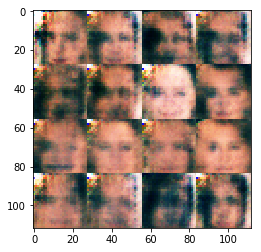

Epoch 1/1... Discriminator Loss: 0.6249... Generator Loss: 1.0993
Epoch 1/1... Discriminator Loss: 0.6577... Generator Loss: 1.1444
Epoch 1/1... Discriminator Loss: 1.4726... Generator Loss: 0.5267
Epoch 1/1... Discriminator Loss: 0.6380... Generator Loss: 1.6465
Epoch 1/1... Discriminator Loss: 0.8393... Generator Loss: 1.3676
Epoch 1/1... Discriminator Loss: 1.0855... Generator Loss: 0.7734
Epoch 1/1... Discriminator Loss: 1.3172... Generator Loss: 0.8747
Epoch 1/1... Discriminator Loss: 0.7797... Generator Loss: 1.9968
Epoch 1/1... Discriminator Loss: 1.6954... Generator Loss: 0.3546
Epoch 1/1... Discriminator Loss: 1.2051... Generator Loss: 0.7836


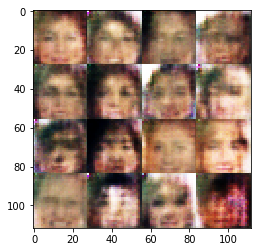

Epoch 1/1... Discriminator Loss: 1.1442... Generator Loss: 1.1203
Epoch 1/1... Discriminator Loss: 1.3082... Generator Loss: 0.4579
Epoch 1/1... Discriminator Loss: 1.2233... Generator Loss: 0.7008
Epoch 1/1... Discriminator Loss: 0.9078... Generator Loss: 1.3998
Epoch 1/1... Discriminator Loss: 1.5583... Generator Loss: 0.5244
Epoch 1/1... Discriminator Loss: 0.9936... Generator Loss: 0.7600
Epoch 1/1... Discriminator Loss: 1.2920... Generator Loss: 0.5394
Epoch 1/1... Discriminator Loss: 1.8543... Generator Loss: 0.3336
Epoch 1/1... Discriminator Loss: 1.2431... Generator Loss: 1.0146
Epoch 1/1... Discriminator Loss: 1.7818... Generator Loss: 0.2703


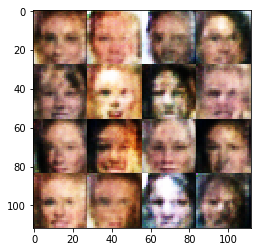

Epoch 1/1... Discriminator Loss: 0.8770... Generator Loss: 0.8748
Epoch 1/1... Discriminator Loss: 1.2610... Generator Loss: 0.7015
Epoch 1/1... Discriminator Loss: 1.6029... Generator Loss: 0.4494
Epoch 1/1... Discriminator Loss: 1.1675... Generator Loss: 1.0638
Epoch 1/1... Discriminator Loss: 1.7496... Generator Loss: 0.3256
Epoch 1/1... Discriminator Loss: 1.5313... Generator Loss: 0.6121
Epoch 1/1... Discriminator Loss: 1.0215... Generator Loss: 0.8573
Epoch 1/1... Discriminator Loss: 1.2956... Generator Loss: 0.5246
Epoch 1/1... Discriminator Loss: 1.2233... Generator Loss: 0.8331
Epoch 1/1... Discriminator Loss: 1.2180... Generator Loss: 0.6999


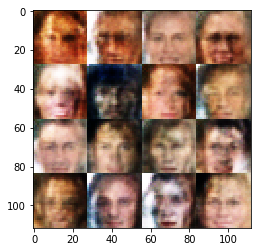

Epoch 1/1... Discriminator Loss: 1.1750... Generator Loss: 1.0528
Epoch 1/1... Discriminator Loss: 1.8951... Generator Loss: 0.2814
Epoch 1/1... Discriminator Loss: 1.8632... Generator Loss: 0.2707
Epoch 1/1... Discriminator Loss: 1.3548... Generator Loss: 0.7828
Epoch 1/1... Discriminator Loss: 1.8655... Generator Loss: 0.2722
Epoch 1/1... Discriminator Loss: 1.5481... Generator Loss: 0.4763
Epoch 1/1... Discriminator Loss: 1.5067... Generator Loss: 0.5442
Epoch 1/1... Discriminator Loss: 1.2672... Generator Loss: 0.7751
Epoch 1/1... Discriminator Loss: 1.5043... Generator Loss: 0.4858
Epoch 1/1... Discriminator Loss: 1.2430... Generator Loss: 0.7044


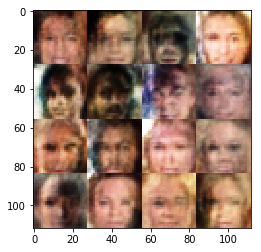

Epoch 1/1... Discriminator Loss: 1.5914... Generator Loss: 0.7636
Epoch 1/1... Discriminator Loss: 1.5295... Generator Loss: 0.7816
Epoch 1/1... Discriminator Loss: 1.3802... Generator Loss: 0.5242
Epoch 1/1... Discriminator Loss: 1.1890... Generator Loss: 0.6117
Epoch 1/1... Discriminator Loss: 1.2982... Generator Loss: 0.6206
Epoch 1/1... Discriminator Loss: 1.2725... Generator Loss: 0.9404
Epoch 1/1... Discriminator Loss: 1.4056... Generator Loss: 0.8378
Epoch 1/1... Discriminator Loss: 1.7119... Generator Loss: 0.3765
Epoch 1/1... Discriminator Loss: 1.4228... Generator Loss: 1.0587
Epoch 1/1... Discriminator Loss: 1.2582... Generator Loss: 0.8421


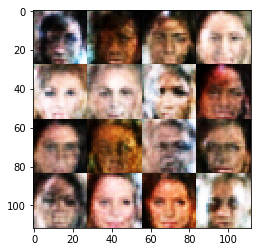

Epoch 1/1... Discriminator Loss: 1.0919... Generator Loss: 1.0147
Epoch 1/1... Discriminator Loss: 1.4371... Generator Loss: 0.4845
Epoch 1/1... Discriminator Loss: 1.4087... Generator Loss: 0.5756
Epoch 1/1... Discriminator Loss: 1.4533... Generator Loss: 0.7097
Epoch 1/1... Discriminator Loss: 1.3186... Generator Loss: 0.6477
Epoch 1/1... Discriminator Loss: 1.4041... Generator Loss: 0.5467
Epoch 1/1... Discriminator Loss: 1.2995... Generator Loss: 0.7452
Epoch 1/1... Discriminator Loss: 1.3100... Generator Loss: 0.8735
Epoch 1/1... Discriminator Loss: 1.3612... Generator Loss: 0.5915
Epoch 1/1... Discriminator Loss: 1.2888... Generator Loss: 0.7734


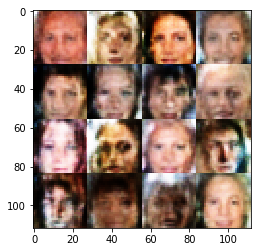

Epoch 1/1... Discriminator Loss: 1.5949... Generator Loss: 0.4076
Epoch 1/1... Discriminator Loss: 1.4262... Generator Loss: 0.4639
Epoch 1/1... Discriminator Loss: 1.3967... Generator Loss: 0.5544
Epoch 1/1... Discriminator Loss: 1.2853... Generator Loss: 0.7828
Epoch 1/1... Discriminator Loss: 1.4625... Generator Loss: 0.4766
Epoch 1/1... Discriminator Loss: 1.3681... Generator Loss: 0.6467
Epoch 1/1... Discriminator Loss: 1.4400... Generator Loss: 0.5950
Epoch 1/1... Discriminator Loss: 1.4501... Generator Loss: 0.5211
Epoch 1/1... Discriminator Loss: 1.4331... Generator Loss: 0.5860
Epoch 1/1... Discriminator Loss: 1.4734... Generator Loss: 0.4990


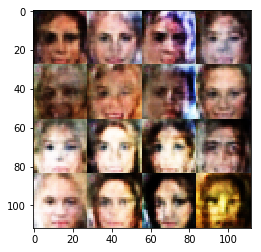

Epoch 1/1... Discriminator Loss: 1.4426... Generator Loss: 0.4957
Epoch 1/1... Discriminator Loss: 1.3196... Generator Loss: 0.6459
Epoch 1/1... Discriminator Loss: 1.5296... Generator Loss: 0.5283
Epoch 1/1... Discriminator Loss: 1.2897... Generator Loss: 0.7376
Epoch 1/1... Discriminator Loss: 1.1118... Generator Loss: 0.8989
Epoch 1/1... Discriminator Loss: 1.5162... Generator Loss: 0.6017
Epoch 1/1... Discriminator Loss: 1.4595... Generator Loss: 0.6127
Epoch 1/1... Discriminator Loss: 1.3271... Generator Loss: 0.7666
Epoch 1/1... Discriminator Loss: 1.5599... Generator Loss: 0.4987
Epoch 1/1... Discriminator Loss: 1.5508... Generator Loss: 0.6630


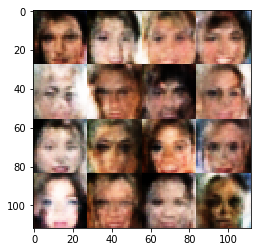

Epoch 1/1... Discriminator Loss: 1.3992... Generator Loss: 0.7642
Epoch 1/1... Discriminator Loss: 1.3847... Generator Loss: 0.6083
Epoch 1/1... Discriminator Loss: 1.5828... Generator Loss: 0.5400
Epoch 1/1... Discriminator Loss: 1.3719... Generator Loss: 0.6775
Epoch 1/1... Discriminator Loss: 1.4183... Generator Loss: 0.7663
Epoch 1/1... Discriminator Loss: 1.3789... Generator Loss: 0.6254
Epoch 1/1... Discriminator Loss: 1.4643... Generator Loss: 0.7496
Epoch 1/1... Discriminator Loss: 1.4035... Generator Loss: 0.6696
Epoch 1/1... Discriminator Loss: 1.3702... Generator Loss: 0.6994
Epoch 1/1... Discriminator Loss: 1.4115... Generator Loss: 0.6286


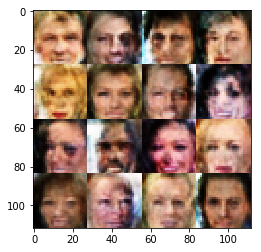

Epoch 1/1... Discriminator Loss: 1.4744... Generator Loss: 0.5847
Epoch 1/1... Discriminator Loss: 1.0765... Generator Loss: 0.9194
Epoch 1/1... Discriminator Loss: 1.3764... Generator Loss: 0.5802
Epoch 1/1... Discriminator Loss: 1.3934... Generator Loss: 0.6639
Epoch 1/1... Discriminator Loss: 1.4228... Generator Loss: 0.6440
Epoch 1/1... Discriminator Loss: 1.3531... Generator Loss: 0.7068
Epoch 1/1... Discriminator Loss: 1.4574... Generator Loss: 0.5186
Epoch 1/1... Discriminator Loss: 1.5819... Generator Loss: 0.4377
Epoch 1/1... Discriminator Loss: 1.4511... Generator Loss: 0.7367
Epoch 1/1... Discriminator Loss: 1.5408... Generator Loss: 0.4315


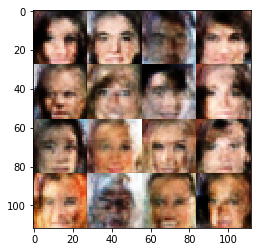

Epoch 1/1... Discriminator Loss: 1.4604... Generator Loss: 0.5125
Epoch 1/1... Discriminator Loss: 1.4501... Generator Loss: 0.5081
Epoch 1/1... Discriminator Loss: 1.4229... Generator Loss: 0.6263
Epoch 1/1... Discriminator Loss: 1.3009... Generator Loss: 0.8932
Epoch 1/1... Discriminator Loss: 1.2962... Generator Loss: 0.6407
Epoch 1/1... Discriminator Loss: 1.1830... Generator Loss: 0.7966
Epoch 1/1... Discriminator Loss: 1.4022... Generator Loss: 0.6165
Epoch 1/1... Discriminator Loss: 1.1868... Generator Loss: 0.9149
Epoch 1/1... Discriminator Loss: 1.3747... Generator Loss: 0.6156
Epoch 1/1... Discriminator Loss: 1.3720... Generator Loss: 0.5536


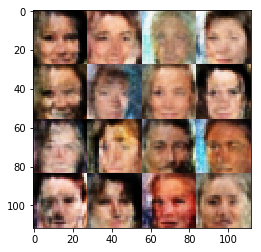

Epoch 1/1... Discriminator Loss: 1.4646... Generator Loss: 0.6466
Epoch 1/1... Discriminator Loss: 1.3999... Generator Loss: 0.6906
Epoch 1/1... Discriminator Loss: 1.4105... Generator Loss: 0.6521
Epoch 1/1... Discriminator Loss: 1.3518... Generator Loss: 0.6776
Epoch 1/1... Discriminator Loss: 1.4484... Generator Loss: 0.6258
Epoch 1/1... Discriminator Loss: 1.4605... Generator Loss: 0.4943
Epoch 1/1... Discriminator Loss: 1.3569... Generator Loss: 0.5588
Epoch 1/1... Discriminator Loss: 1.3075... Generator Loss: 0.6790
Epoch 1/1... Discriminator Loss: 1.4061... Generator Loss: 0.6129
Epoch 1/1... Discriminator Loss: 1.3958... Generator Loss: 0.7830


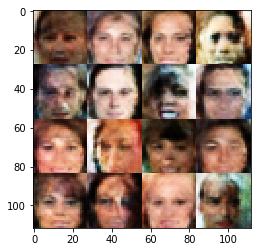

Epoch 1/1... Discriminator Loss: 1.3659... Generator Loss: 0.6918
Epoch 1/1... Discriminator Loss: 1.3677... Generator Loss: 0.6173
Epoch 1/1... Discriminator Loss: 1.5054... Generator Loss: 0.5118
Epoch 1/1... Discriminator Loss: 1.4524... Generator Loss: 0.6618
Epoch 1/1... Discriminator Loss: 1.3348... Generator Loss: 0.6715
Epoch 1/1... Discriminator Loss: 1.6651... Generator Loss: 0.4183
Epoch 1/1... Discriminator Loss: 1.3991... Generator Loss: 0.5282
Epoch 1/1... Discriminator Loss: 1.5470... Generator Loss: 0.4539
Epoch 1/1... Discriminator Loss: 1.1937... Generator Loss: 0.7899
Epoch 1/1... Discriminator Loss: 1.4937... Generator Loss: 0.5057


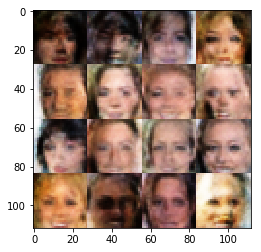

Epoch 1/1... Discriminator Loss: 1.4189... Generator Loss: 0.5694
Epoch 1/1... Discriminator Loss: 1.3939... Generator Loss: 0.6490
Epoch 1/1... Discriminator Loss: 1.3282... Generator Loss: 0.7081
Epoch 1/1... Discriminator Loss: 1.2686... Generator Loss: 0.7055
Epoch 1/1... Discriminator Loss: 1.3815... Generator Loss: 0.6656
Epoch 1/1... Discriminator Loss: 1.3313... Generator Loss: 0.8165
Epoch 1/1... Discriminator Loss: 1.4569... Generator Loss: 0.5213
Epoch 1/1... Discriminator Loss: 1.5559... Generator Loss: 0.4281
Epoch 1/1... Discriminator Loss: 1.4339... Generator Loss: 0.4713
Epoch 1/1... Discriminator Loss: 1.4213... Generator Loss: 0.6887


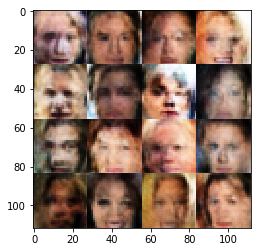

Epoch 1/1... Discriminator Loss: 1.2694... Generator Loss: 0.7579
Epoch 1/1... Discriminator Loss: 1.3762... Generator Loss: 0.6131
Epoch 1/1... Discriminator Loss: 1.2825... Generator Loss: 1.0452
Epoch 1/1... Discriminator Loss: 1.4948... Generator Loss: 0.5470
Epoch 1/1... Discriminator Loss: 1.4404... Generator Loss: 0.5097
Epoch 1/1... Discriminator Loss: 1.4624... Generator Loss: 0.6325
Epoch 1/1... Discriminator Loss: 1.3577... Generator Loss: 0.6089
Epoch 1/1... Discriminator Loss: 1.4007... Generator Loss: 0.5001
Epoch 1/1... Discriminator Loss: 1.4906... Generator Loss: 0.4890
Epoch 1/1... Discriminator Loss: 1.4691... Generator Loss: 0.6000


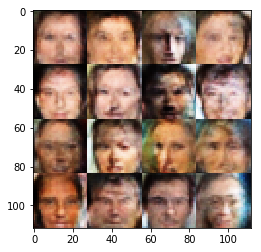

Epoch 1/1... Discriminator Loss: 1.3136... Generator Loss: 0.6280
Epoch 1/1... Discriminator Loss: 1.3936... Generator Loss: 0.7173
Epoch 1/1... Discriminator Loss: 1.3248... Generator Loss: 0.6521
Epoch 1/1... Discriminator Loss: 1.2418... Generator Loss: 0.7807
Epoch 1/1... Discriminator Loss: 1.4340... Generator Loss: 0.6223
Epoch 1/1... Discriminator Loss: 1.5395... Generator Loss: 0.4435
Epoch 1/1... Discriminator Loss: 1.3557... Generator Loss: 0.5885
Epoch 1/1... Discriminator Loss: 1.2946... Generator Loss: 0.5670
Epoch 1/1... Discriminator Loss: 1.2571... Generator Loss: 0.8303
Epoch 1/1... Discriminator Loss: 1.3402... Generator Loss: 0.6372


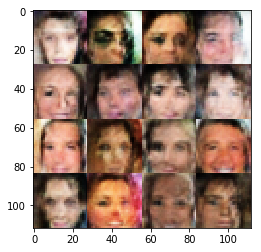

Epoch 1/1... Discriminator Loss: 1.5088... Generator Loss: 0.4746
Epoch 1/1... Discriminator Loss: 1.3487... Generator Loss: 0.6405
Epoch 1/1... Discriminator Loss: 1.4189... Generator Loss: 0.5400
Epoch 1/1... Discriminator Loss: 0.9763... Generator Loss: 1.1782
Epoch 1/1... Discriminator Loss: 1.3702... Generator Loss: 0.5472
Epoch 1/1... Discriminator Loss: 1.4394... Generator Loss: 0.4956
Epoch 1/1... Discriminator Loss: 1.3424... Generator Loss: 0.5585
Epoch 1/1... Discriminator Loss: 1.4527... Generator Loss: 0.5432
Epoch 1/1... Discriminator Loss: 1.4014... Generator Loss: 0.4858
Epoch 1/1... Discriminator Loss: 1.2948... Generator Loss: 0.5503


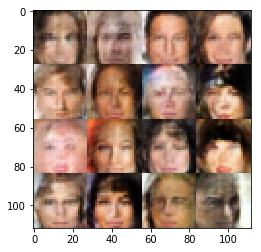

Epoch 1/1... Discriminator Loss: 1.4700... Generator Loss: 0.6253
Epoch 1/1... Discriminator Loss: 1.3711... Generator Loss: 0.4926
Epoch 1/1... Discriminator Loss: 1.4355... Generator Loss: 0.4724
Epoch 1/1... Discriminator Loss: 1.6033... Generator Loss: 0.3340
Epoch 1/1... Discriminator Loss: 1.4116... Generator Loss: 0.5794
Epoch 1/1... Discriminator Loss: 1.5212... Generator Loss: 0.5754
Epoch 1/1... Discriminator Loss: 1.2785... Generator Loss: 0.6618
Epoch 1/1... Discriminator Loss: 1.3170... Generator Loss: 0.7745
Epoch 1/1... Discriminator Loss: 1.2472... Generator Loss: 0.6917
Epoch 1/1... Discriminator Loss: 1.3966... Generator Loss: 0.6847


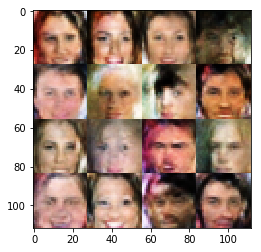

Epoch 1/1... Discriminator Loss: 1.3697... Generator Loss: 0.5740
Epoch 1/1... Discriminator Loss: 1.2888... Generator Loss: 0.6026
Epoch 1/1... Discriminator Loss: 1.2586... Generator Loss: 0.5119
Epoch 1/1... Discriminator Loss: 1.1573... Generator Loss: 0.9146
Epoch 1/1... Discriminator Loss: 1.2768... Generator Loss: 0.4873
Epoch 1/1... Discriminator Loss: 1.1689... Generator Loss: 0.8063
Epoch 1/1... Discriminator Loss: 1.4165... Generator Loss: 1.0320
Epoch 1/1... Discriminator Loss: 1.3230... Generator Loss: 0.6472
Epoch 1/1... Discriminator Loss: 1.4166... Generator Loss: 0.5154
Epoch 1/1... Discriminator Loss: 1.2088... Generator Loss: 0.7326


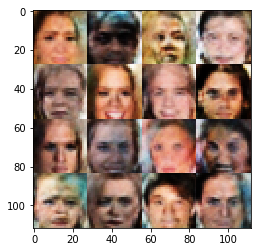

Epoch 1/1... Discriminator Loss: 1.2971... Generator Loss: 0.6597
Epoch 1/1... Discriminator Loss: 1.1790... Generator Loss: 0.8232
Epoch 1/1... Discriminator Loss: 1.2222... Generator Loss: 0.6716
Epoch 1/1... Discriminator Loss: 1.4108... Generator Loss: 0.4780
Epoch 1/1... Discriminator Loss: 1.2392... Generator Loss: 0.5572
Epoch 1/1... Discriminator Loss: 1.3649... Generator Loss: 1.0270
Epoch 1/1... Discriminator Loss: 1.3085... Generator Loss: 0.6734
Epoch 1/1... Discriminator Loss: 1.4528... Generator Loss: 0.3808
Epoch 1/1... Discriminator Loss: 1.3289... Generator Loss: 0.6726
Epoch 1/1... Discriminator Loss: 1.3051... Generator Loss: 0.7345


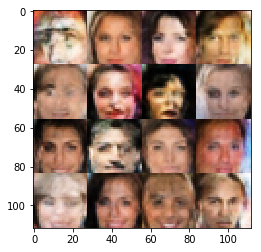

Epoch 1/1... Discriminator Loss: 1.2088... Generator Loss: 0.7058
Epoch 1/1... Discriminator Loss: 1.4624... Generator Loss: 0.4252
Epoch 1/1... Discriminator Loss: 1.3610... Generator Loss: 0.4677
Epoch 1/1... Discriminator Loss: 1.0812... Generator Loss: 0.9672
Epoch 1/1... Discriminator Loss: 1.5000... Generator Loss: 0.4336
Epoch 1/1... Discriminator Loss: 1.2728... Generator Loss: 0.5295
Epoch 1/1... Discriminator Loss: 1.1098... Generator Loss: 0.8547
Epoch 1/1... Discriminator Loss: 1.2216... Generator Loss: 0.8797
Epoch 1/1... Discriminator Loss: 1.4134... Generator Loss: 0.4030
Epoch 1/1... Discriminator Loss: 1.2131... Generator Loss: 0.6363


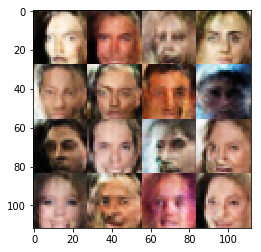

Epoch 1/1... Discriminator Loss: 1.3052... Generator Loss: 0.4379
Epoch 1/1... Discriminator Loss: 1.3816... Generator Loss: 0.7251
Epoch 1/1... Discriminator Loss: 1.1266... Generator Loss: 0.6856
Epoch 1/1... Discriminator Loss: 1.2135... Generator Loss: 0.5859
Epoch 1/1... Discriminator Loss: 1.4085... Generator Loss: 0.8143
Epoch 1/1... Discriminator Loss: 1.1927... Generator Loss: 0.6859
Epoch 1/1... Discriminator Loss: 0.9954... Generator Loss: 0.8018
Epoch 1/1... Discriminator Loss: 1.2090... Generator Loss: 0.5895
Epoch 1/1... Discriminator Loss: 1.0356... Generator Loss: 0.6661
Epoch 1/1... Discriminator Loss: 1.1943... Generator Loss: 1.1243


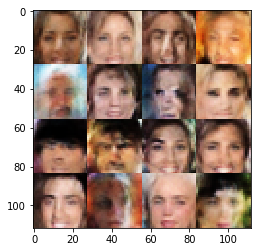

Epoch 1/1... Discriminator Loss: 1.1856... Generator Loss: 0.5546
Epoch 1/1... Discriminator Loss: 1.1010... Generator Loss: 1.1076
Epoch 1/1... Discriminator Loss: 1.0540... Generator Loss: 0.9771
Epoch 1/1... Discriminator Loss: 1.2794... Generator Loss: 1.2371
Epoch 1/1... Discriminator Loss: 0.9773... Generator Loss: 0.8468
Epoch 1/1... Discriminator Loss: 1.4711... Generator Loss: 1.5282
Epoch 1/1... Discriminator Loss: 1.2818... Generator Loss: 0.5405
Epoch 1/1... Discriminator Loss: 1.2266... Generator Loss: 0.4666
Epoch 1/1... Discriminator Loss: 0.8800... Generator Loss: 0.9537
Epoch 1/1... Discriminator Loss: 1.2463... Generator Loss: 0.5380


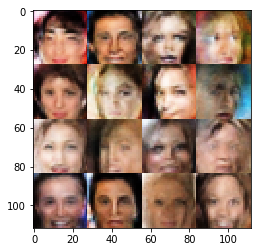

Epoch 1/1... Discriminator Loss: 1.3075... Generator Loss: 0.4504
Epoch 1/1... Discriminator Loss: 1.2465... Generator Loss: 0.4649
Epoch 1/1... Discriminator Loss: 1.2797... Generator Loss: 0.9872
Epoch 1/1... Discriminator Loss: 1.1201... Generator Loss: 0.7933
Epoch 1/1... Discriminator Loss: 1.4008... Generator Loss: 1.1080
Epoch 1/1... Discriminator Loss: 1.3984... Generator Loss: 1.1204
Epoch 1/1... Discriminator Loss: 1.2558... Generator Loss: 0.4696
Epoch 1/1... Discriminator Loss: 1.0803... Generator Loss: 0.9637
Epoch 1/1... Discriminator Loss: 1.0496... Generator Loss: 0.6315
Epoch 1/1... Discriminator Loss: 1.2552... Generator Loss: 0.9718


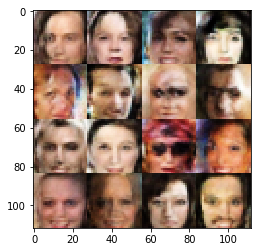

Epoch 1/1... Discriminator Loss: 1.3315... Generator Loss: 0.5480
Epoch 1/1... Discriminator Loss: 1.2016... Generator Loss: 0.5017
Epoch 1/1... Discriminator Loss: 1.2434... Generator Loss: 0.4733
Epoch 1/1... Discriminator Loss: 1.0184... Generator Loss: 0.9701
Epoch 1/1... Discriminator Loss: 1.1748... Generator Loss: 0.6697
Epoch 1/1... Discriminator Loss: 1.3693... Generator Loss: 0.3744
Epoch 1/1... Discriminator Loss: 0.8815... Generator Loss: 1.0448
Epoch 1/1... Discriminator Loss: 1.6075... Generator Loss: 0.4659
Epoch 1/1... Discriminator Loss: 1.0146... Generator Loss: 0.6575
Epoch 1/1... Discriminator Loss: 1.4363... Generator Loss: 0.3795


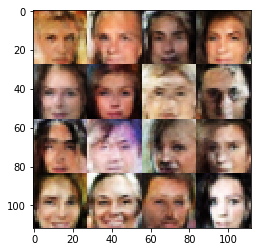

Epoch 1/1... Discriminator Loss: 1.1504... Generator Loss: 0.6379
Epoch 1/1... Discriminator Loss: 1.2280... Generator Loss: 0.4233
Epoch 1/1... Discriminator Loss: 0.9895... Generator Loss: 0.6553
Epoch 1/1... Discriminator Loss: 1.7428... Generator Loss: 1.5722
Epoch 1/1... Discriminator Loss: 1.4469... Generator Loss: 0.3881
Epoch 1/1... Discriminator Loss: 1.0740... Generator Loss: 0.9204
Epoch 1/1... Discriminator Loss: 1.6415... Generator Loss: 0.3069
Epoch 1/1... Discriminator Loss: 0.8166... Generator Loss: 1.1887
Epoch 1/1... Discriminator Loss: 1.5558... Generator Loss: 0.3032
Epoch 1/1... Discriminator Loss: 1.4693... Generator Loss: 0.3361


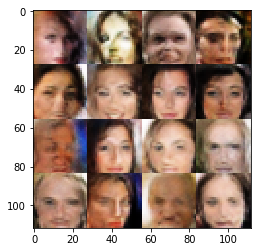

Epoch 1/1... Discriminator Loss: 0.8668... Generator Loss: 1.5264
Epoch 1/1... Discriminator Loss: 1.0003... Generator Loss: 0.6919
Epoch 1/1... Discriminator Loss: 1.1179... Generator Loss: 0.5274
Epoch 1/1... Discriminator Loss: 0.8773... Generator Loss: 0.8801
Epoch 1/1... Discriminator Loss: 0.9484... Generator Loss: 0.9159
Epoch 1/1... Discriminator Loss: 1.6380... Generator Loss: 0.2769
Epoch 1/1... Discriminator Loss: 1.3646... Generator Loss: 2.1610
Epoch 1/1... Discriminator Loss: 0.8205... Generator Loss: 1.8169
Epoch 1/1... Discriminator Loss: 0.8675... Generator Loss: 0.8152
Epoch 1/1... Discriminator Loss: 0.8388... Generator Loss: 0.8802


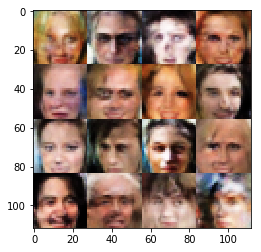

Epoch 1/1... Discriminator Loss: 0.8016... Generator Loss: 0.8558
Epoch 1/1... Discriminator Loss: 1.0586... Generator Loss: 1.0402
Epoch 1/1... Discriminator Loss: 0.8702... Generator Loss: 1.1315
Epoch 1/1... Discriminator Loss: 1.7833... Generator Loss: 1.7266
Epoch 1/1... Discriminator Loss: 1.1038... Generator Loss: 0.6460
Epoch 1/1... Discriminator Loss: 0.8237... Generator Loss: 0.9587
Epoch 1/1... Discriminator Loss: 1.3021... Generator Loss: 0.4005
Epoch 1/1... Discriminator Loss: 1.0936... Generator Loss: 0.5852
Epoch 1/1... Discriminator Loss: 1.0795... Generator Loss: 0.6617
Epoch 1/1... Discriminator Loss: 1.3337... Generator Loss: 0.4054


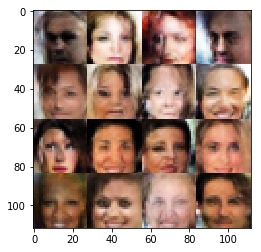

Epoch 1/1... Discriminator Loss: 1.3411... Generator Loss: 0.4091
Epoch 1/1... Discriminator Loss: 1.7593... Generator Loss: 2.1437
Epoch 1/1... Discriminator Loss: 0.9541... Generator Loss: 0.7789
Epoch 1/1... Discriminator Loss: 1.1101... Generator Loss: 0.4956
Epoch 1/1... Discriminator Loss: 0.8904... Generator Loss: 0.7612
Epoch 1/1... Discriminator Loss: 1.1961... Generator Loss: 0.4602
Epoch 1/1... Discriminator Loss: 1.1055... Generator Loss: 0.8870
Epoch 1/1... Discriminator Loss: 0.8233... Generator Loss: 0.8449
Epoch 1/1... Discriminator Loss: 0.9446... Generator Loss: 0.9314
Epoch 1/1... Discriminator Loss: 0.7887... Generator Loss: 0.9354


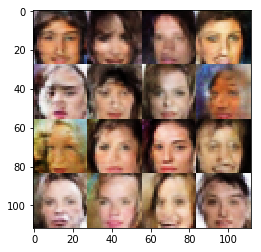

Epoch 1/1... Discriminator Loss: 0.8686... Generator Loss: 1.0654
Epoch 1/1... Discriminator Loss: 0.5632... Generator Loss: 1.1809
Epoch 1/1... Discriminator Loss: 0.6490... Generator Loss: 1.3892
Epoch 1/1... Discriminator Loss: 1.4129... Generator Loss: 1.6673
Epoch 1/1... Discriminator Loss: 1.2047... Generator Loss: 0.9813
Epoch 1/1... Discriminator Loss: 0.8055... Generator Loss: 1.1480


In [16]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.4


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### 提交项目
提交本项目前，确保运行所有 cells 后保存该文件。

保存该文件为 "dlnd_face_generation.ipynb"， 并另存为 HTML 格式 "File" -> "Download as"。提交项目时请附带 "helper.py" 和 "problem_unittests.py" 文件。